In [172]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

# 1. Introductory Concepts

<b>Distribution objects</b> capture the essencial operations on probability distributions.

## 1.1 Univariate Distributions

Univariate distributions are distribution of a single random variable.

$$\begin{align}
\mathcal{N} &= (\mu,\sigma) \\
\mu &= 0 \\
\sigma &= 1 \\
\end{align}$$

In [173]:
# Create a univariate normal distribution with μ=0 and σ=1

normal = tfd.Normal(loc=0, scale=1)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

Notice the properties `batch_shape` and `event_shape`. The `event_shape` property is what captures the dimensionality of the random variable. In this case we are using a univariate distribution, that is why the `event_shape` is empty. 

What can we do with this distribution object. We can, for instance, sample from it.

In [174]:
# Draw one sample from the normal distribution

normal.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=0.058266275>

In [175]:
# Draw 3 samples from the normal distribution

normal.sample(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.30202267,  1.2635828 ,  1.2478709 ], dtype=float32)>

We can also evaluate the Probability Density Function (PDF), in the case of continuous random variables, on a given input.

In [176]:
# Calculate the pdf(0.2)

normal.prob(0.2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3910427>

We will usually use the log probability of a given input.

In [177]:
# Calculate the log_prob(0.2)

normal.log_prob(0.2)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9389385>

In [178]:
# It is simply the log of the value returned by the prob method 

np.log(normal.prob(0.2))

-0.9389385

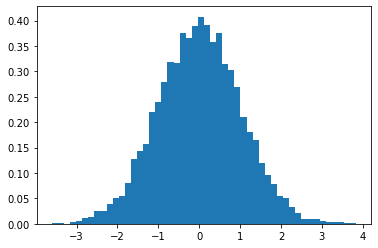

In [179]:
# Plot a histogram, approximating the density of the distribution

plt.hist(normal.sample(10000).numpy(), bins=50, density=True)
plt.show()

We can also represent in a single object a batch of distribution of the same type.

In [180]:
# Create two univariate normal distributions:
# one with μ=0 and σ=1
# and another with μ=1 and σ=1

normal_batch = tfd.Normal([0, 1],1)
normal_batch

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

Notice the batch shape in the object above, it has a batch shape of two, meaning that we have two different normal distributions represented in that object. We can obviously sample from this distribution.

In [181]:
# Sample from the batch 2 normal distribution

normal_batch.sample(3)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-1.4486663 ,  2.1130714 ],
       [-0.85912985,  0.8926701 ],
       [-0.5956301 ,  0.16556042]], dtype=float32)>

Now, the shape of our samples is (3,2), as we are drawing 3 samples from each normal distribution. The same way we can get the values for the PDFs of both distributions.

In [182]:
# Get the PDF values for the batch distribution

normal_batch.prob([1,2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.24197073, 0.24197073], dtype=float32)>

The returned shape is the original batch shape. We can go crazy with dimensionality.

In [183]:
# Use a batch shape with higher rank

normal_batch_nD = tfd.Normal([[[0., 1],
                             [0.5, 1],
                             [3, 2]]], scale=1)
normal_batch_nD

<tfp.distributions.Normal 'Normal' batch_shape=[1, 3, 2] event_shape=[] dtype=float32>

In [184]:
# Sample from the batch of distributions

normal_batch_nD.sample(10)

<tf.Tensor: shape=(10, 1, 3, 2), dtype=float32, numpy=
array([[[[ 0.52337795,  0.64297   ],
         [-0.69964314,  0.58262706],
         [ 1.9748341 ,  3.7000346 ]]],


       [[[-1.8335208 ,  1.1546469 ],
         [ 0.08698025,  2.6438842 ],
         [ 2.5595856 ,  2.4680154 ]]],


       [[[-0.9307612 ,  0.2640723 ],
         [-1.6138644 ,  1.3090308 ],
         [ 3.1739514 ,  0.9706086 ]]],


       [[[-3.232416  , -0.14331603],
         [-0.62904036,  0.07588911],
         [ 1.5890679 ,  2.600162  ]]],


       [[[ 0.29451978, -0.57438385],
         [-1.7437241 ,  1.9871583 ],
         [ 2.0440638 ,  2.3980274 ]]],


       [[[-0.25111732,  0.53991663],
         [ 0.5523139 ,  2.0330272 ],
         [-0.21795988,  1.1809968 ]]],


       [[[ 2.1080973 ,  2.9275312 ],
         [ 0.485002  ,  1.8112307 ],
         [ 3.50988   ,  2.7244084 ]]],


       [[[ 0.04118196,  1.1321232 ],
         [ 1.33672   ,  0.11671829],
         [ 3.063174  ,  2.3953094 ]]],


       [[[ 0.03408352,  2

In [185]:
normal_batch_nD.sample(10).shape

TensorShape([10, 1, 3, 2])

The shape is now (10, 1, 3, 2), where the first dimension is the sample size and the rest are the batched distributions.

## 1.2 Multivariate Distributions

Let's start by defining a multivariate normal distribution. There are multiple ways to do it that you can check in the documentation. It is defined as:

$$\begin{align}
\mathcal{N_1} &= (\mu_1,\Sigma_1) \\
\mu_1 &= [0, 1] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 2
\end{bmatrix}
\end{align}$$

In [186]:
# Create a multivariate normal distribution with diagonal covariance
# with μ = [0, 1] and σ = [1, 2]

mv_normal = tfd.MultivariateNormalDiag(loc=[0, 1], scale_diag=[1., 2])
mv_normal

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

Notice the difference from the distributions that we have created above. The `event_shape` is now 2, indicating that the random variable for this distribution is 2-dimensional.

In [187]:
# Sample from the multivariate normal

mv_normal.sample(3)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.47630158, -3.2896776 ],
       [ 2.1817942 , -2.6470141 ],
       [-1.6997765 , -0.57287264]], dtype=float32)>

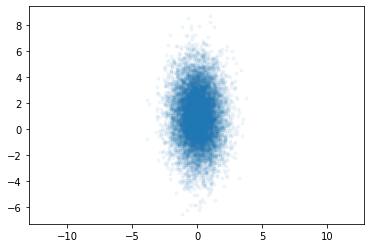

In [188]:
# Plot the samples of the distribution

plt_sample = mv_normal.sample(10000).numpy()
plt.scatter(plt_sample[:,0], plt_sample[:,1], marker='.', alpha=0.05)
plt.axis('equal')
plt.show()

The data is more spread out in the second dimension (y-axis) as we defined a scale that is twice the value used for the first dimension. Also, there is no correlation between the dimensions, as we used a diagonal multivariate normal distribution (off-diagonal terms are 0).

We can define a batch of multivariate distributions.

$$\begin{align}
\mathcal{N_1} &= (\mu_1,\Sigma_1) \\
\mu_1 &= [0, 0] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 2
\end{bmatrix} \\[10pt]
\mathcal{N_2} &= (\mu_2,\Sigma_2) \\
\mu_1 &= [1, 1] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix} \\[10pt]
\mathcal{N_3} &= (\mu_3,\Sigma_3) \\
\mu_1 &= [0, 0] \\
\Sigma_1 &= \begin{bmatrix}
2 & 0\\
0 & 10
\end{bmatrix}
\end{align}$$

In [189]:
# Create 3 batches of multivariate normals

normal_diag_batch = tfd.MultivariateNormalDiag(loc=[[0,0], [1,1], [0,0]],
                                              scale_diag=[[1,2], [1,1], [2,10]])

In [190]:
# sample from the distribution

samples = normal_diag_batch.sample(10000).numpy()
samples

array([[[ 1.4146564 ,  4.888121  ],
        [ 1.243983  , -0.85801446],
        [ 2.6551135 , -7.0267677 ]],

       [[ 1.1387651 , -3.1490428 ],
        [ 1.7774832 ,  1.6095812 ],
        [ 1.7227676 , -0.86594313]],

       [[-0.10546044,  1.9006096 ],
        [ 1.5164343 ,  1.7439076 ],
        [ 0.8410673 , -0.8707316 ]],

       ...,

       [[ 0.5205298 , -3.0766077 ],
        [ 2.639357  , -0.20498955],
        [-0.67683715,  1.6409132 ]],

       [[-0.9768474 ,  0.82698303],
        [ 2.3373728 ,  0.86186504],
        [ 0.33705965,  0.4292664 ]],

       [[ 0.19859616,  1.6853503 ],
        [-0.26115656, -1.58863   ],
        [ 2.5262434 , 11.058707  ]]], dtype=float32)

When sampling we get an output with the following dimensions (number_samples, batch_shape, event_shape).

In [191]:
# Compute log probs

normal_diag_batch.log_prob(samples)

<tf.Tensor: shape=(10000, 3), dtype=float32, numpy=
array([[-6.5183663, -3.5937498, -5.96169  ],
       [-4.418976 , -2.3259115, -5.2083497],
       [-2.9881248, -2.2479284, -4.9258246],
       ...,
       [-3.8496895, -3.9076228, -4.904336 ],
       [-3.0936272, -2.7417006, -4.848732 ],
       [-2.905795 , -5.983638 , -6.2428226]], dtype=float32)>

The log-probability has shape (number_samples, batch_shape) as expected.

In [192]:
# create a sample for a plot

plt_sample_batch = normal_diag_batch.sample(10000).numpy()
plt_sample_batch.shape # (samples, batch, event)

(10000, 3, 2)

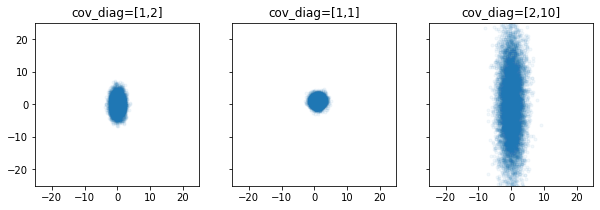

In [193]:
# Plot the samples of the mv normal

fig, axs = (plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3)))
titles = ['cov_diag=[1,2]', 'cov_diag=[1,1]', f'cov_diag=[2,10]']

for i, (ax, title) in enumerate(zip(axs, titles)):
    samples = plt_sample_batch[:,i,:] # take the ith batch, gives a shape (samples, event_shape)
    ax.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.05)
    ax.set_title(title)
    axs[i].set_ylim(-25, 25)
    axs[i].set_xlim(-25, 25)
plt.show()

## 1.3 Independent Distribution

There are cases where we want to interpret a batch of independent distributions over an event space as a single joint distribution over a product of event spaces. This impacts the way we handle the batch and event shapes. An example of such a problem is the Naive Bayes classifier, where the features are independent given a class label.

To illustrate, let's define two normal distributions.
The first is a multivariate normal of the form:
$$\begin{align}
\mathcal{N_1} &= (\mu_1,\Sigma_1) \\
\mu_1 &= [0, 1] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 2
\end{bmatrix}
\end{align}$$


The second is a batched normal of the form:
$$\begin{align}
\mathcal{N_{2_1}} &= (\mu_{2_1},\sigma_{2_1}) \\
\mu_{2_1} &= 0 \\
\sigma_{2_1} &= 1 \\[10pt]
\mathcal{N_{2_2}} &= (\mu_{2_2},\sigma_{2_2}) \\
\mu_{2_2} &= 1 \\
\sigma_{2_2} &= 2
\end{align}$$

In [194]:
# Create a multivariate normal diagonal distribution
# with μ=[0,1], σ=[1, 2]

mv_normal = tfd.MultivariateNormalDiag(loc=[0, 1], scale_diag=[1,2])
mv_normal.log_prob([0.2, 1.5])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.5822742>

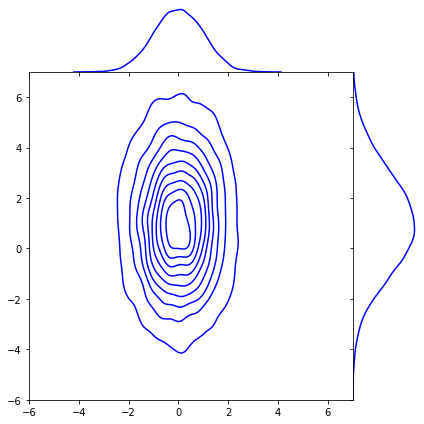

In [195]:
# Plot the independent dist

samples = mv_normal.sample(10000).numpy()
x1 = samples[:,0]
x2 = samples[:,1]
sns.jointplot(x = x1, y = x2, kind='kde', space=0, color='b', xlim=[-6, 7], ylim=[-6, 7]);

In [196]:
# Create a batched normal distribution
# with μ=[0,1], σ=[1, 2]

locs = [0,1]
scales = [1, 2]

batched_normal = tfd.Normal(loc=locs, scale=scales)
batched_normal.log_prob([0.2, 1.5])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.9389385, -1.6433357], dtype=float32)>

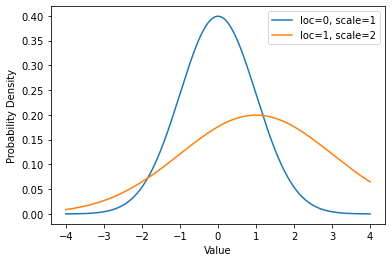

In [197]:
# Plot the batched normal

t = np.linspace(-4, 4, 10000)
densities = batched_normal.prob(np.repeat(t[:, np.newaxis], 2, axis=1))

sns.lineplot(x=t, y=densities[:, 0], label='loc={}, scale={}'.format(locs[0], scales[0]))
sns.lineplot(x=t, y=densities[:, 1], label='loc={}, scale={}'.format(locs[1], scales[1]))
plt.ylabel('Probability Density')
plt.xlabel('Value')
plt.legend()
plt.show()

Notice that the first distribution object returns a single log-probability while the second returns 2. The difference is that the array that we pass to the first is interpreted as a single realization of a 2-dimensional random variable. In the second case, the array is interpreted as different inputs for each of the random variables (also referred as batches).

In a nutshell the Independent distribution allows us to absorb whatever dimesions we want to absorb to the event dimension.

In [198]:
# Create an independent normal dist from the batched normal dist created above

independent_normal = tfd.Independent(batched_normal, reinterpreted_batch_ndims=1)
independent_normal

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [199]:
independent_normal.log_prob([0.2, 1.5])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.5822742>

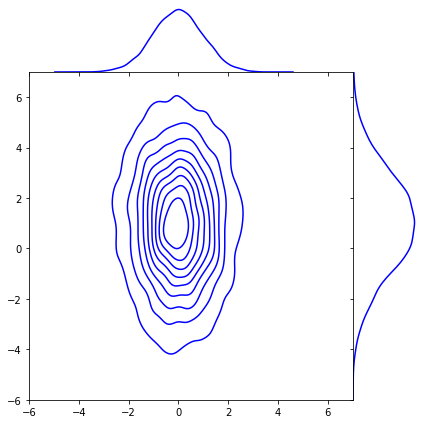

In [200]:
# Plot the independent dist

samples = independent_normal.sample(10000).numpy()
x1 = samples[:,0]
x2 = samples[:,1]
sns.jointplot(x = x1, y = x2, kind='kde', space=0, color='b', xlim=[-6, 7], ylim=[-6, 7]);

Notice that now the independent normal created from the batched normal is equivalent to the multivariate normal created above.

## 1.4 Trainable Parameters

Now that we know the essencials about TensorFlow Probability objects, it is time to understand how we can train parameters for these distributions. This is the connection that we are missing to start applying what we have learned. 

In TensorFlow, `Variable` objects are what we use to capture the values of parameter of our deep learning models. These objects are updated during training by, for example, applying gradients obtained from a loss function and data.

In [201]:
# Create a normal distribution with the μ parameter trainable

normal = tfd.Normal(loc=tf.Variable(0., name='loc'), scale=5)
normal.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.0>,)

For the training procedure, Maximum Likelihood is the usual suspect in deep learning models. In a nutshell, we are looking for the parameters of our model that maximize the probability of the data. 

The probability density function of a continuous random variable roughly indicates the probability of a sample taking a particular value. We will denote this function $P(x | \theta)$ where $x$ is the value of the sample and $\theta$ is the parameter describing the probability distribution:

$$
P(x | \theta) = \text{Prob} (\text{sampling value $x$ from a distribution with parameter $\theta$}).
$$

In [202]:
# Calculate pdf of 0 for a standard normal dist

tfd.Normal(0, 1).prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3989423>

When more than one sample is drawn *independently* from the same distribution (which we usually assume), the probability density function of the sample values $x_1, \ldots, x_n$ is the product of the probability density functions for each individual $x_i$. Written formally:

$$
P(x_1, \ldots, x_n | \theta) = \prod_{i=1}^n P(x_i | \theta).
$$

In [203]:
X = [-0.5, 0, 1.5]

np.prod(tfd.Normal(0, 1).prob(X))

0.01819123

Probability density functions are usually considered functions of $x_1, \ldots, x_n$, with the parameter $\theta$ considered fixed. They are used when you know the parameter $\theta$ and want to know the probability of a sample taking some values $x_1, \ldots, x_n$. You use this function in *probability*, where you know the distribution and want to make deductions about possible values sampled from it.

The *likelihood* function is the same, but with the $x_1, \ldots, x_n$ considered fixed and with $\theta$ considered the independent variable. You usually use this function when you know the sample values $x_1, \ldots, x_n$ (because you've observed them by collecting data), but don't know the parameter $\theta$. You use this function in *statistics*, where you know the data and want to make inferences about the distribution they came from. 

For the likelihood, the convention is using the letter $L$, so that

$$
\underbrace{L(x_1, \ldots, x_n | \theta)}_{\text{ likelihood,} \\ \text{function of $\theta$}} = \underbrace{P(x_1, \ldots, x_n | \theta)}_{\text{probabiliy density,} \\ \text{ function of $x_1, \ldots, x_n$}}
$$

We are ready to define our likelihood function for a normal distribution with parameters $\mu$ and $\sigma$:

$$\begin{aligned}
L = f(X|\theta) &= f(x_1|\theta) f(x_2|\theta),..., f(x_n|\theta) \\
&= \prod^n_{j=1}f(X| \mu,\sigma^2) \\
&= (2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(x_i-\mu)^2\big)}
\end{aligned}$$

In [204]:
# Create a grid of values for μ and σ and calculate the likelihood
# for the different parameter values

μ = np.linspace(-2, 2, 100)
σ = np.linspace(0, 3, 100)

l_x = []
for mu in μ:
    for sigma in σ:
        l_x.append(np.prod(tfd.Normal(mu, sigma).prob(X)))
        
l_x = np.asarray(l_x).reshape((100, 100)).T

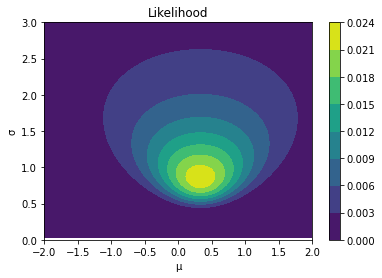

In [205]:
# Plot the likelihood based on the observed data (fixed)

plt.contourf(μ, σ, l_x)
plt.xlabel('μ')
plt.ylabel('σ')
plt.colorbar()
plt.title('Likelihood');

We now get to a new problem, multiplying many small probabilities together can be numerically unstable. To overcome this, we can use the log of the same function. The natural logarithm is a monotonically increasing function, which means that if the value on the x-axis increases, the value on the y-axis also increases. This is important because it ensures that the maximum value of the log of the probability occurs at the same point as the original probability function. It does another very conveniently thing for us, it transforms our products into sums.

Let's perform the transformation:

$$\begin{aligned}
\log(L(X|\theta)) &= \log\big((2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(y_i-\mu)^2\big)\big)} \\
&= -\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(y_i-\mu)^2
\end{aligned}$$

Almost there! We will now work our optimization problem at hand. We can put it as simple as

$$\max_{\mu,\sigma^2}\log(L(X|\theta))$$

The expression derived above can be differentiated to find the maximum. Expanding our parameters we have $\log(L(X|\mu, \sigma))$. As it is a function of the two variables $\mu$ and $\sigma$ we use partial derivatives to find the MLE. 

Let's focus on $\hat \mu$ (the hat indicates that it is an estimator, i.e. our output), we compute it from

$$\begin{aligned}
& \quad \frac{\partial}{\partial \mu} \log(L(Y|\mu, \sigma)) \\
&= \frac{\partial}{\partial \mu} \big(-\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(x_i-\mu)^2\big)
\\
&= \sum^n_{j=1} \frac{(x_i - \mu)}{\sigma^2}
\end{aligned}$$

Setting the expression above equal to zero we get


$$\sum^n_{j=1} \frac{(x_i - \mu)}{\sigma^2} = 0 $$

Then
$$\begin{aligned}
\hat\mu &= \frac{\sum^n_{j=1}x_i}{n} \\
\hat\mu &= \bar x
\end{aligned}$$

Surprisingly or not this is the mean of the data.

In [206]:
# Get maximum values for the μ and σ and compare with true values

index_mu_max = np.argmax(l_x, axis=1)[-1]
print(f'μ True Value: {np.array(X).mean()}')
print(f'μ Calculated Value: {μ[index_mu_max]}')
print(f'σ True Value: {np.array(X).std()}')
print(f'σ Calculated Value: {σ[np.nanargmax(l_x[:,index_mu_max], axis=0)]}')

μ True Value: 0.3333333333333333
μ Calculated Value: 0.3434343434343434
σ True Value: 0.8498365855987975
σ Calculated Value: 0.8484848484848485


##### Calculate using TensorFlow

In [207]:
# Create a random variable normall distributed and sample from it

x_train = np.random.normal(loc=1, scale=5, size=1000).astype('float32')[:, np.newaxis]

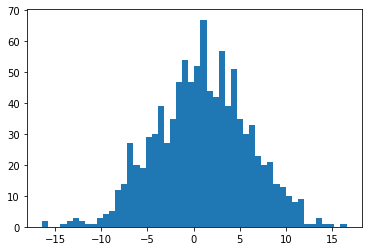

In [208]:
# Plot a histogram of the random variable

plt.hist(x_train, bins=50);

In [209]:
# Calculate the mean of the samples of the random variable

x_train.mean()

0.9283262

In [210]:
# Define the negative log likelihood function (loss function)

def nll(x_train):
    return -tf.reduce_sum(normal.log_prob(x_train))

Notice that above we are supplying data points to our model and computing the corresponding log-probability for each data point. As we already saw, the `log_prob` method returns a tensor that has the same shape as the data. The log-probability of our data will be the sum of the log-probabilities of each data point.

In [211]:
# Custom training loop

@tf.function
def get_loss_and_grads(x_train):
    with tf.GradientTape() as tape:
        tape.watch(normal.trainable_variables)
        loss = nll(x_train)
        grads = tape.gradient(loss, normal.trainable_variables)
    return loss, grads

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

for i in range(2000):
    loss, grads = get_loss_and_grads(x_train)
    optimizer.apply_gradients(zip(grads, normal.trainable_variables))
    
    loc_value = normal.loc.value()
    print("Step {:03d}: Loss: {:.3f} Loc: {:.3f}".format(i, loss, loc_value))


Step 000: Loss: 3049.112 Loc: 0.037
Step 001: Loss: 3047.761 Loc: 0.073
Step 002: Loss: 3046.516 Loc: 0.107
Step 003: Loss: 3045.367 Loc: 0.140
Step 004: Loss: 3044.310 Loc: 0.171
Step 005: Loss: 3043.335 Loc: 0.202
Step 006: Loss: 3042.437 Loc: 0.231
Step 007: Loss: 3041.609 Loc: 0.259
Step 008: Loss: 3040.846 Loc: 0.285
Step 009: Loss: 3040.143 Loc: 0.311
Step 010: Loss: 3039.494 Loc: 0.336
Step 011: Loss: 3038.897 Loc: 0.360
Step 012: Loss: 3038.347 Loc: 0.382
Step 013: Loss: 3037.839 Loc: 0.404
Step 014: Loss: 3037.372 Loc: 0.425
Step 015: Loss: 3036.941 Loc: 0.445
Step 016: Loss: 3036.544 Loc: 0.465
Step 017: Loss: 3036.178 Loc: 0.483
Step 018: Loss: 3035.841 Loc: 0.501
Step 019: Loss: 3035.530 Loc: 0.518
Step 020: Loss: 3035.243 Loc: 0.534
Step 021: Loss: 3034.979 Loc: 0.550
Step 022: Loss: 3034.736 Loc: 0.565
Step 023: Loss: 3034.512 Loc: 0.580
Step 024: Loss: 3034.305 Loc: 0.594
Step 025: Loss: 3034.115 Loc: 0.607
Step 026: Loss: 3033.939 Loc: 0.620
Step 027: Loss: 3033.778 Loc

Step 387: Loss: 3031.876 Loc: 0.928
Step 388: Loss: 3031.876 Loc: 0.928
Step 389: Loss: 3031.876 Loc: 0.928
Step 390: Loss: 3031.876 Loc: 0.928
Step 391: Loss: 3031.876 Loc: 0.928
Step 392: Loss: 3031.876 Loc: 0.928
Step 393: Loss: 3031.876 Loc: 0.928
Step 394: Loss: 3031.876 Loc: 0.928
Step 395: Loss: 3031.876 Loc: 0.928
Step 396: Loss: 3031.876 Loc: 0.928
Step 397: Loss: 3031.876 Loc: 0.928
Step 398: Loss: 3031.876 Loc: 0.928
Step 399: Loss: 3031.876 Loc: 0.928
Step 400: Loss: 3031.876 Loc: 0.928
Step 401: Loss: 3031.876 Loc: 0.928
Step 402: Loss: 3031.876 Loc: 0.928
Step 403: Loss: 3031.876 Loc: 0.928
Step 404: Loss: 3031.876 Loc: 0.928
Step 405: Loss: 3031.876 Loc: 0.928
Step 406: Loss: 3031.876 Loc: 0.928
Step 407: Loss: 3031.876 Loc: 0.928
Step 408: Loss: 3031.876 Loc: 0.928
Step 409: Loss: 3031.876 Loc: 0.928
Step 410: Loss: 3031.876 Loc: 0.928
Step 411: Loss: 3031.876 Loc: 0.928
Step 412: Loss: 3031.876 Loc: 0.928
Step 413: Loss: 3031.876 Loc: 0.928
Step 414: Loss: 3031.876 Loc

Step 755: Loss: 3031.876 Loc: 0.928
Step 756: Loss: 3031.876 Loc: 0.928
Step 757: Loss: 3031.876 Loc: 0.928
Step 758: Loss: 3031.876 Loc: 0.928
Step 759: Loss: 3031.876 Loc: 0.928
Step 760: Loss: 3031.876 Loc: 0.928
Step 761: Loss: 3031.876 Loc: 0.928
Step 762: Loss: 3031.876 Loc: 0.928
Step 763: Loss: 3031.876 Loc: 0.928
Step 764: Loss: 3031.876 Loc: 0.928
Step 765: Loss: 3031.876 Loc: 0.928
Step 766: Loss: 3031.876 Loc: 0.928
Step 767: Loss: 3031.876 Loc: 0.928
Step 768: Loss: 3031.876 Loc: 0.928
Step 769: Loss: 3031.876 Loc: 0.928
Step 770: Loss: 3031.876 Loc: 0.928
Step 771: Loss: 3031.876 Loc: 0.928
Step 772: Loss: 3031.876 Loc: 0.928
Step 773: Loss: 3031.876 Loc: 0.928
Step 774: Loss: 3031.876 Loc: 0.928
Step 775: Loss: 3031.876 Loc: 0.928
Step 776: Loss: 3031.876 Loc: 0.928
Step 777: Loss: 3031.876 Loc: 0.928
Step 778: Loss: 3031.876 Loc: 0.928
Step 779: Loss: 3031.876 Loc: 0.928
Step 780: Loss: 3031.876 Loc: 0.928
Step 781: Loss: 3031.876 Loc: 0.928
Step 782: Loss: 3031.876 Loc

Step 1153: Loss: 3031.876 Loc: 0.928
Step 1154: Loss: 3031.876 Loc: 0.928
Step 1155: Loss: 3031.876 Loc: 0.928
Step 1156: Loss: 3031.876 Loc: 0.928
Step 1157: Loss: 3031.876 Loc: 0.928
Step 1158: Loss: 3031.876 Loc: 0.928
Step 1159: Loss: 3031.876 Loc: 0.928
Step 1160: Loss: 3031.876 Loc: 0.928
Step 1161: Loss: 3031.876 Loc: 0.928
Step 1162: Loss: 3031.876 Loc: 0.928
Step 1163: Loss: 3031.876 Loc: 0.928
Step 1164: Loss: 3031.876 Loc: 0.928
Step 1165: Loss: 3031.876 Loc: 0.928
Step 1166: Loss: 3031.876 Loc: 0.928
Step 1167: Loss: 3031.876 Loc: 0.928
Step 1168: Loss: 3031.876 Loc: 0.928
Step 1169: Loss: 3031.876 Loc: 0.928
Step 1170: Loss: 3031.876 Loc: 0.928
Step 1171: Loss: 3031.876 Loc: 0.928
Step 1172: Loss: 3031.876 Loc: 0.928
Step 1173: Loss: 3031.876 Loc: 0.928
Step 1174: Loss: 3031.876 Loc: 0.928
Step 1175: Loss: 3031.876 Loc: 0.928
Step 1176: Loss: 3031.876 Loc: 0.928
Step 1177: Loss: 3031.876 Loc: 0.928
Step 1178: Loss: 3031.876 Loc: 0.928
Step 1179: Loss: 3031.876 Loc: 0.928
S

Step 1555: Loss: 3031.876 Loc: 0.928
Step 1556: Loss: 3031.876 Loc: 0.928
Step 1557: Loss: 3031.876 Loc: 0.928
Step 1558: Loss: 3031.876 Loc: 0.928
Step 1559: Loss: 3031.876 Loc: 0.928
Step 1560: Loss: 3031.876 Loc: 0.928
Step 1561: Loss: 3031.876 Loc: 0.928
Step 1562: Loss: 3031.876 Loc: 0.928
Step 1563: Loss: 3031.876 Loc: 0.928
Step 1564: Loss: 3031.876 Loc: 0.928
Step 1565: Loss: 3031.876 Loc: 0.928
Step 1566: Loss: 3031.876 Loc: 0.928
Step 1567: Loss: 3031.876 Loc: 0.928
Step 1568: Loss: 3031.876 Loc: 0.928
Step 1569: Loss: 3031.876 Loc: 0.928
Step 1570: Loss: 3031.876 Loc: 0.928
Step 1571: Loss: 3031.876 Loc: 0.928
Step 1572: Loss: 3031.876 Loc: 0.928
Step 1573: Loss: 3031.876 Loc: 0.928
Step 1574: Loss: 3031.876 Loc: 0.928
Step 1575: Loss: 3031.876 Loc: 0.928
Step 1576: Loss: 3031.876 Loc: 0.928
Step 1577: Loss: 3031.876 Loc: 0.928
Step 1578: Loss: 3031.876 Loc: 0.928
Step 1579: Loss: 3031.876 Loc: 0.928
Step 1580: Loss: 3031.876 Loc: 0.928
Step 1581: Loss: 3031.876 Loc: 0.928
S

Step 1951: Loss: 3031.876 Loc: 0.928
Step 1952: Loss: 3031.876 Loc: 0.928
Step 1953: Loss: 3031.876 Loc: 0.928
Step 1954: Loss: 3031.876 Loc: 0.928
Step 1955: Loss: 3031.876 Loc: 0.928
Step 1956: Loss: 3031.876 Loc: 0.928
Step 1957: Loss: 3031.876 Loc: 0.928
Step 1958: Loss: 3031.876 Loc: 0.928
Step 1959: Loss: 3031.876 Loc: 0.928
Step 1960: Loss: 3031.876 Loc: 0.928
Step 1961: Loss: 3031.876 Loc: 0.928
Step 1962: Loss: 3031.876 Loc: 0.928
Step 1963: Loss: 3031.876 Loc: 0.928
Step 1964: Loss: 3031.876 Loc: 0.928
Step 1965: Loss: 3031.876 Loc: 0.928
Step 1966: Loss: 3031.876 Loc: 0.928
Step 1967: Loss: 3031.876 Loc: 0.928
Step 1968: Loss: 3031.876 Loc: 0.928
Step 1969: Loss: 3031.876 Loc: 0.928
Step 1970: Loss: 3031.876 Loc: 0.928
Step 1971: Loss: 3031.876 Loc: 0.928
Step 1972: Loss: 3031.876 Loc: 0.928
Step 1973: Loss: 3031.876 Loc: 0.928
Step 1974: Loss: 3031.876 Loc: 0.928
Step 1975: Loss: 3031.876 Loc: 0.928
Step 1976: Loss: 3031.876 Loc: 0.928
Step 1977: Loss: 3031.876 Loc: 0.928
S

In [212]:
# Compare the true value and the estimated parameter

print(f'True Value: {x_train.mean()}')
print(f'Estimated Value: {normal.trainable_variables[0].numpy()}')

True Value: 0.9283261895179749
Estimated Value: 0.9283254146575928


# 2. Linear Regression

#### Create data

The data we'll be working with is artificially created from the following equation:

$$y_i = x_i + \frac{3}{10}\epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed

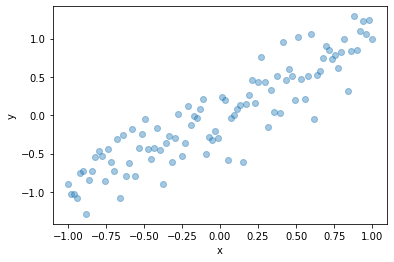

In [213]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Let's define a model that receives each input as a length one vector (`input_shape`=(1,)) and the model is predicting only one target variable (using a Dense layer with 1 unit). We are compiling the model with the mean squared error loss, using the `RMSprop` optimizer and training for 200 epochs.

In [214]:
# Create linear regression via Sequential model
# Train the deterministic linear model using mean squared error loss

model = Sequential([
    Dense(units=1, input_shape=(1,)),
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


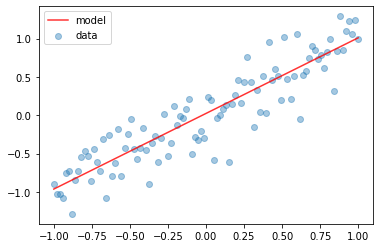

In [215]:
# Plot the data and the model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

The deterministic linear regression fails to capture the aleatoric uncertainty (uncertainty on the process generation of the data). We can see this by the output above, where we get the y_value (our prediction) but we don't get any reference to the uncertainty of that prediction (there is significant uncertainty as we can see from the distance between the blue points and the red line).

#### Probabilistic linear regression to model the aleatoric uncertainty

To build our probabilistic model, we add a final layer which is a `DistributionLambda` layer. This layer includes the normal distribution. Notice that the output of the previous layer is what defines the mean of the normal distribution and we are assuming that the standard deviation is fixed (in our case 0.6). The constructor of the `DistributionLambda` has one required argument which is a function. This function takes the output of the previous layer as an input and returns a distribution object. In this case we are using a lambda function to instantiate the `DistributionLambda` layer. The lambda function receives an input t, which is the output tensor of the previous `Dense` layer and returns a normal distribution with mean defined by the tensor t.

With this setup the model returns a distribution object when it is called.

In [216]:
# Create probabilistic regression with normal distribution as final layer

model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=0.6))
])
model(x_train)

<tfp.distributions.Normal 'sequential_29_distribution_lambda_18_Normal' batch_shape=[100, 1] event_shape=[] dtype=float32>

Notice that the output of the model is a distribution object with `batch_shape` equal to batch of the data (we did not create batches) by the number of units in the `Dense` layer (or number of ouput variables).

In [217]:
# Print model summary

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 1)                 2         
_________________________________________________________________
distribution_lambda_18 (Dist multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


It is time to define our loss function. The loss function in `Keras` receives the true labels and predictions as inputs. To compute the negative loglikelihood we just need to bear in mind that our model outputs a distribution object, so `y_pred` is the normal distribution. Using the `log_prob` method, we can easily compute the log probability of the data.

In [218]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [219]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=200, verbose=False)

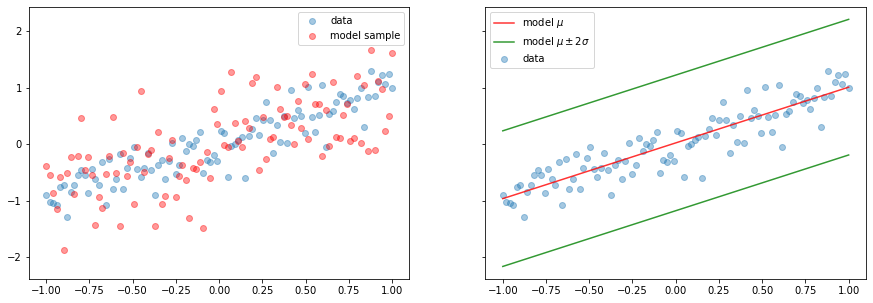

In [220]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

As we can see we capture the mean correctly but as we did not infer the standard deviation (it was manually chosen) we see that its value is far from correct. Let's add the standard deviation as a parameter of the model.

We need to constraint the standard deviation to be positive. We use a SoftPlus function, which is a smooth approximation to the ReLU function and can indeed constrain the output of a model to always be positive.

In [221]:
# Create probabilistic regression with normal distribution as final layer

event_shape = 1

model = Sequential([
    Dense(units=2, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t:tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:])))
])
model(x_train)

<tfp.distributions.Normal 'sequential_30_distribution_lambda_19_Normal' batch_shape=[100, 1] event_shape=[] dtype=float32>

In [222]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_19 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [223]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [224]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=200, verbose=False)

In [225]:
# Examine the distribution created as a feedforward value

y_model = model(x_train)
y_model

<tfp.distributions.Normal 'sequential_30_distribution_lambda_19_Normal' batch_shape=[100, 1] event_shape=[] dtype=float32>

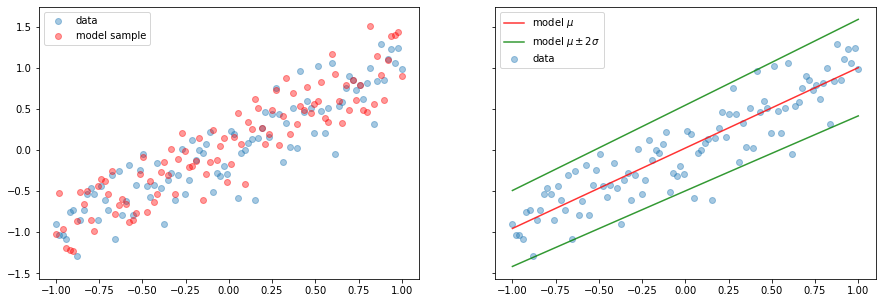

In [226]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

# 3. Non-Linear Regression

#### Probabilitistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:

$$y_i = x_i^3+\frac{2}{5}(1+x_i)\epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed.

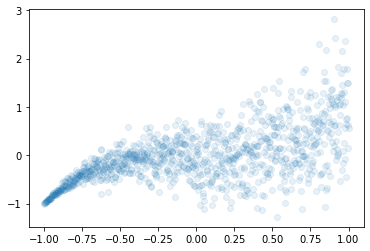

In [227]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + (2/5)*(1+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

To simplify the implementation of our last layer we can use a wrapper that TensorFlow Probability provides to build a similar distribution that we built with `DistributionLambda` - it is called `IndependentNormal`. At the same time we can use a static method that outputs the number of parameters that are required to the probabilistic layer and use it to define the number of units in the previous `Dense` layer: `tfpl.IndependentNormal.params_size(event_shape=1)`.

The real difference between the linear and non-linear models is that we added a new Dense layer as the first layer of the model.

In [228]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
    # Dense(2),
    # tfpl.DistributionLambda(lambda t:tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:])))
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_5 (Indepe multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [229]:
# Train model

model.fit(x_train, y_train, epochs=500, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 534us/step - loss: 0.4136


0.4135710895061493

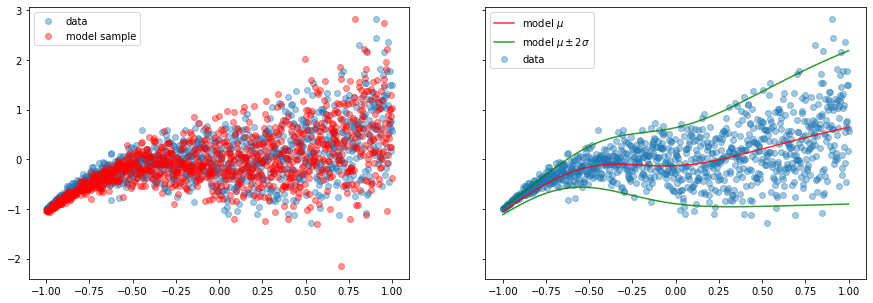

In [230]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

# 4. Deterministic Deep Learning Model

### 4.1 The MNIST and MNIST-C datasets

In this article we use the MNIST dataset and its corrupted version [MNIST](http://yann.lecun.com/exdb/mnist/). The corrupted version have grey spatters on top of the numbers, make it harder to classify the numbers. Our goal is to build a Convolutional Neural Network (CNN) that classifies the images of the handwritten digits to 10 different classes.

In [231]:
def load_data(name):
    data_dir = os.path.join('data', name)
    x_train = 1 - np.load(os.path.join(data_dir, 'x_train.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    x_test  = 1 - np.load(os.path.join(data_dir, 'x_test.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)
    
    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

In [232]:
# Function to inspect dataset digits

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, :, :], cmap='gray')
        ax[i].axis('off')
    plt.show()

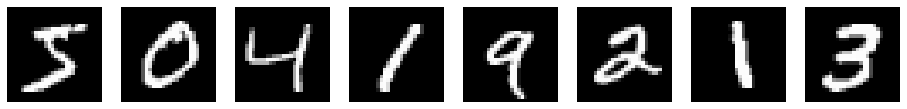

In [233]:
# Load and inspect the MNIST dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

inspect_images(data=x_train, num_images=8)

In [234]:
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [235]:
# Load and inspect the MNIST-C dataset

(xy_c_train, xy_c_test) = tfds.load('mnist_corrupted/spatter',
                               split=['train', 'test'],
                               as_supervised=True)

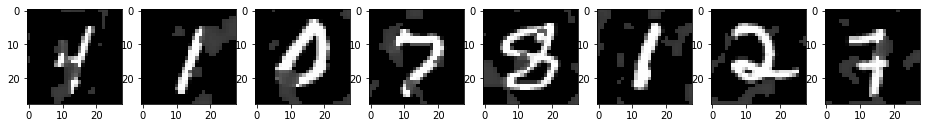

In [236]:
i = 0
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(2*8, 2))

for x, y in xy_c_train:
    if i < 8:
        ax[i].imshow(np.squeeze(x), cmap='gray')
    else:
        break
    i+=1

In [237]:
# not good practice (doing it here to simplify visualizations essencially)

x_c_train = []
y_c_train = []
for x, y in xy_c_train:
    x_c_train.append(x)
    y_c_train.append(y)
x_c_train = np.asarray(x_c_train)
y_c_train = np.asarray(y_c_train)


x_c_test = []
y_c_test = []
for x, y in xy_c_test:
    x_c_test.append(x)
    y_c_test.append(y)
x_c_test = np.asarray(x_c_test)
y_c_test = np.asarray(y_c_test)

### 4.2 Deterministic CNN

We need to build a classifier model that can output predictions to 10 different classes. In our deterministic model, the final layer has to be defined with a `Dense` layer with 10 units and a softmax activation function.

We first define the deterministic model. It is a CNN classifier model with: 
* a Conv2D layer with 8 filters, 5x5 kernel size, ReLU activation and `'VALID'` padding.
* a MaxPooling2D layer with a 6x6 window size.
* a Flatten layer
* a Dense layer with 10 units and softmax activation

In [238]:
# define a function that returns the deterministic model defined above

def get_deterministic_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        Conv2D(input_shape=input_shape, 
               padding='valid', 
               filters=8, 
               kernel_size=(5, 5), 
               activation='relu'),
        MaxPooling2D(pool_size=(6,6)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [239]:
# Run your function to get the benchmark model

tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28, 1), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [240]:
# Print the model summary

deterministic_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1290      
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [241]:
# Train the model

deterministic_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 6.2778 - accuracy: 0.7035
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2266 - accuracy: 0.9440
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1596 - accuracy: 0.9567
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1344 - accuracy: 0.9635
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1239 - accuracy: 0.9669


In [242]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9629999995231628
Accuracy on corrupted MNIST test set:  0.8743000030517578


The pointwise performance on the corrupted MNIST set is worse as we would expect. The dataset is noisier, which makes it hard to the model to differentiate the classes.

# 5. Probabilistic Deep Learning Model


In [243]:
# Define the negative loglikelihood function

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

For our probabilistic model, the final layer is different from what we defined in the deterministic model. As we saw previously, we want our model to output a distribution object. In this case, the model outputs a One-Hot Categorical distribution object. With this approach we are able to model the aleatoric uncertainty on the image labels.

OneHotCategorical is a discrete distribution over one-hot bit vectors whereas Categorical is a discrete distribution over positive integers. OneHotCategorical is equivalent to Categorical except Categorical has event_dim=() while OneHotCategorical has event_dim=K, where K is the number of classes.

Our probabilistic CNN consists of: 
* a Conv2D layer with 8 filters, 5x5 kernel size, ReLU activation and `'VALID'` padding.
* a MaxPooling2D layer with a 6x6 window size.
* a Flatten layer
* a Dense layer with the number of units required to parameterize the probabilistic layer that follows
* a OneHotCategorical distribution with event shape equal to 10, corresponding to the 10 classes

In [244]:
# Define the probabilistic CNN

def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        Conv2D(input_shape=input_shape, 
               padding='valid', 
               filters=8, 
               kernel_size=(5, 5), 
               activation='relu'),
        MaxPooling2D(pool_size=(6,6)),
        Flatten(),
        Dense(units=tfpl.OneHotCategorical.params_size(10)),
        tfpl.OneHotCategorical(event_size=10,
                               convert_to_tensor_fn=tfd.Distribution.mode)
    ])
    model.compile(loss = loss,
                 optimizer=optimizer,
                 metrics=metrics,
                 experimental_run_tf_function=False)
    return model
    

In [245]:
# Run your function to get the probabilistic model

tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1), 
    loss=nll, 
    optimizer=RMSprop(), 
    metrics=['accuracy'])

In [246]:
# Print the model summary

probabilistic_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                1290      
_________________________________________________________________
one_hot_categorical_1 (OneHo multiple                  0         
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [247]:
# Train the model

probabilistic_model.fit(x_train, tf.keras.utils.to_categorical(y_train), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 6.2778 - accuracy: 0.7035
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2266 - accuracy: 0.9440
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1596 - accuracy: 0.9567
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1344 - accuracy: 0.9635
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1239 - accuracy: 0.9669


In [248]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(probabilistic_model.evaluate(x_test, tf.keras.utils.to_categorical(y_test), verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(probabilistic_model.evaluate(x_c_test, tf.keras.utils.to_categorical(y_c_test), verbose=False)[1]))

Accuracy on MNIST test set:  0.9629999995231628
Accuracy on corrupted MNIST test set:  0.8743000030517578


Note that the test accuracy of the probabilistic model is identical to the deterministic model. This is because the model architectures for both are equivalent; the only difference being that the probabilistic model returns a distribution object.

In [249]:
# Check all the weights of the deterministic and probabilistic 
# models are identical

for deterministic_variable, probabilistic_variable in zip(deterministic_model.weights, probabilistic_model.weights):
    print(np.allclose(deterministic_variable.numpy(), probabilistic_variable.numpy()))

True
True
True
True


# 6. Results

In [250]:
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction(data, true_labels, model, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data
    try:
        if len(true_labels)>0:
            true_labels = np.argmax(true_labels)
    except:
        pass
    true_label = true_labels
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

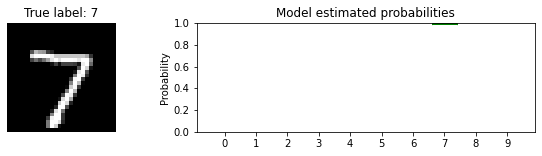

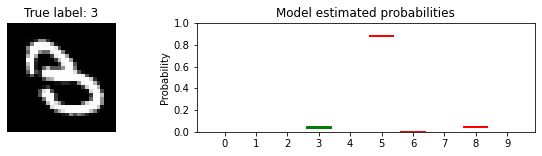

In [266]:
# Prediction examples on MNIST

for i in [0, 18]:
    analyse_model_prediction(x_test[i], np.squeeze(y_test[i]), probabilistic_model)

The model is very confident that the first image is a 7, which is correct. For the second image, the model struggles, assigning nonzero probabilities to many different classes.

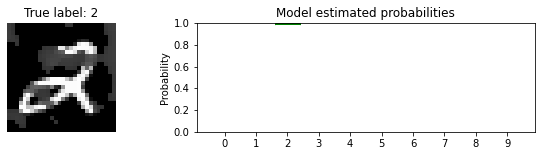

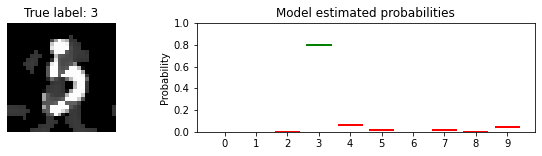

In [265]:
# Prediction examples on MNIST-C

for i in [0, 17]:
    analyse_model_prediction(x_c_test[i], np.squeeze(y_c_test[i]), probabilistic_model)

Once again the model is confident about its prediction of the first image. Despite the spatters, the number is still easy to identify. The second number is significantly harder to identify. The model still does a good job by predicting the right number, but also by showing uncertainty about that choice.

We can also make some analysis of the model's uncertainty across the full test set, instead of for individual values. One way to do this is to calculate the entropy of the distribution. The entropy is the expected information of a random variable, and is a measure of the uncertainty of the random variable. The entropy of the estimated probabilities for sample  𝑖  is defined as

$$
H_i = -\sum_{j=1}^{10} p_{ij} \text{log}_{2}(p_{ij})
$$
 
where  𝑝𝑖𝑗  is the probability that the model assigns to sample  𝑖  corresponding to label  𝑗. The higher the value, the more unsure the model is.

In [253]:
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect

def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

MNIST test set:


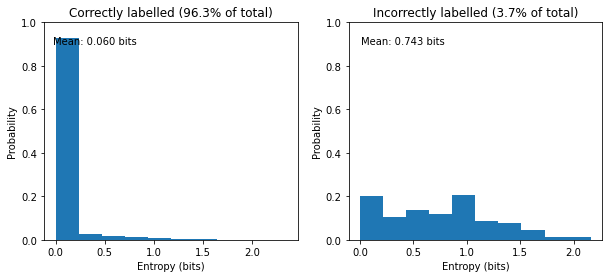

In [254]:
# Entropy plots for the MNIST dataset

print('MNIST test set:')
plot_entropy_distribution(probabilistic_model, x_test, y_test)

Corrupted MNIST test set:


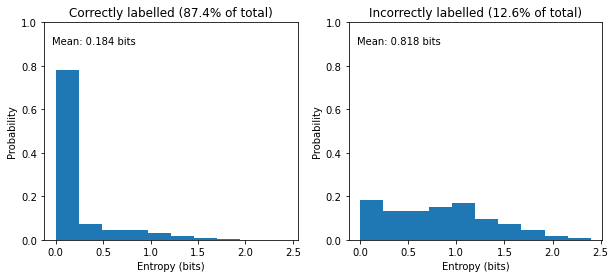

In [255]:
# Entropy plots for the MNIST-C dataset

print('Corrupted MNIST test set:')
plot_entropy_distribution(probabilistic_model, x_c_test, y_c_test)

# 7. Conclusions

From the results above we can see that the model is more unsure on the predictions it got wrong this means it knows when the prediction may be wrong. These are great properties to have in a machine learning model, and is one of the advantages of probabilistic modelling.

# 8. References and Materials

[1] - [Coursera: TensorFlow 2 for Deep Learning Specialization](https://www.coursera.org/specializations/tensorflow2-deeplearning)

[2] - [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

[3] - [TensorFlow Probability Guides and Tutorials](https://www.tensorflow.org/probability/overview)

[4] - [TensorFlow Probability Posts in TensorFlow Blog](https://blog.tensorflow.org/search?label=TensorFlow+Probability&max-results=20)